In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Attention
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

Found 253 files belonging to 2 classes.
Minimum value of the scaled data: 0.0
Maximum value of the scaled data: 1.0
There are 8 batches in our data
Train Size: 4
Validation Size: 2
Test Size: 2
Sum of Train, Validation, and Test sizes is equal to: 8


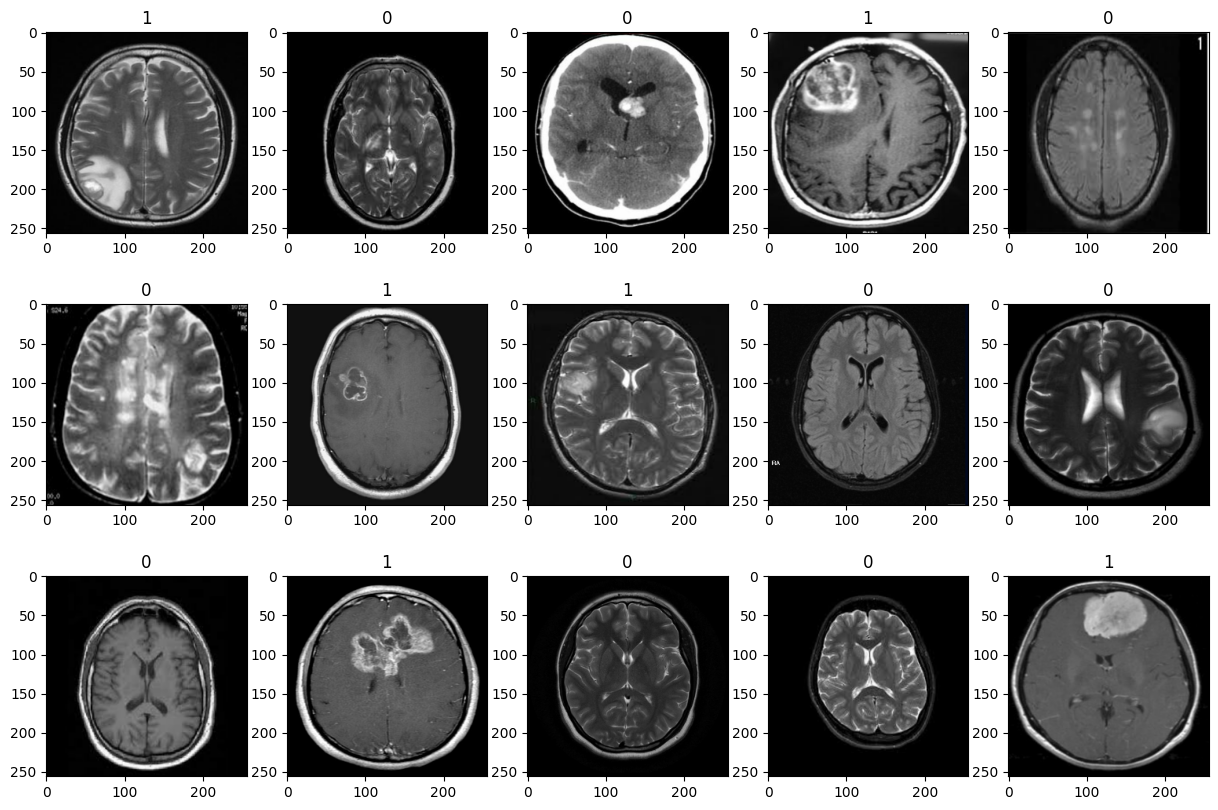

In [2]:
data = keras.utils.image_dataset_from_directory(r"C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset")

batch = data.as_numpy_iterator().next()

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

data = data.map(lambda x, y: (x / 255, y))
batch = data.as_numpy_iterator().next()
print("Minimum value of the scaled data:", batch[0].min())
print("Maximum value of the scaled data:", batch[0].max())
print("There are", len(data), "batches in our data")
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.2) + 1
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)
print("Sum of Train, Validation, and Test sizes is equal to:", train_size + val_size + test_size)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)
batch = data.as_numpy_iterator().next()

In [3]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Data augmentation
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

# Using ResNet-50 as the base model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the pre-trained ResNet-50 model
for layer in base_model.layers:
    layer.trainable = False

# Create an attention layer
attention = Attention()([base_model.output, base_model.output])

# Flatten layer
flat = Flatten()(attention)

# Add dropout for regularization
dropout = Dropout(0.5)(flat)

# Dense layers for classification
dense1 = Dense(128, activation="relu")(dropout)
output = Dense(1, activation="sigmoid")(dense1)

# Build the final model
model = keras.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

# Data augmentation and normalization
train = train.map(lambda x, y: (data_augmentation(x), y))
val = val.map(lambda x, y: (x / 255, y))

# Early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train the model with data augmentation
history = model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping, reduce_lr])



94765736/94765736 [==============================] - 12s 0us/step


Epoch 1/50



4/4 [==============================] - 36s 8s/step - loss: 11.9671 - accuracy: 0.5703 - val_loss: 20.3348 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 24s 6s/step - loss: 13.1822 - accuracy: 0.3984 - val_loss: 0.8686 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 21s 6s/step - loss: 3.0310 - accuracy: 0.6016 - val_loss: 4.0561 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 4/50
4/4 [==============================] - 21s 6s/step - loss: 3.1122 - accuracy: 0.5938 - val_loss: 1.9176 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/50
4/4 [==============================] - 22s 6s/step - loss: 1.5740 - accuracy: 0.6172 - val_loss: 1.1568 - val_accuracy: 0.6250 - lr: 2.0000e-04
Epoch 6/50
4/4 [==============================] - 22s 6s/step - loss: 1.0030 - accuracy: 0.6016 - val_loss: 0.6147 - val_accuracy: 0.7188 - lr: 2.0000e-04
Epoch 7/50
4/4 [==============================] - 21s 6s/step - loss: 0.6821 - accuracy: 0.640

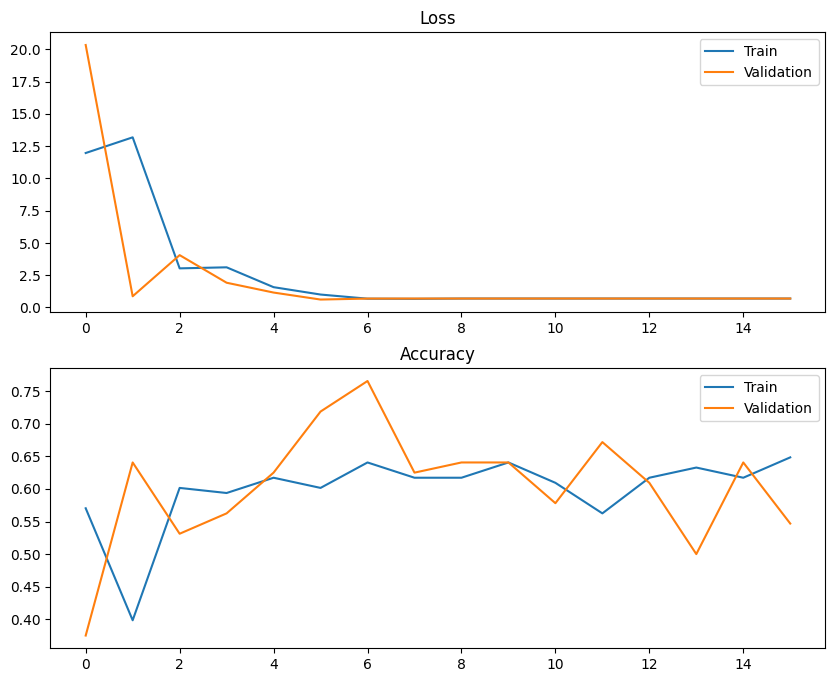

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].plot(history.history["loss"], label="Train")
ax[0].plot(history.history["val_loss"], label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="Train")
ax[1].plot(history.history["val_accuracy"], label="Validation")
ax[1].title.set_text("Accuracy")
ax[1].legend()

plt.show()

In [5]:
bin_acc = BinaryAccuracy()
recall = Recall()
precision = Precision()

y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)
    
    y_true_list.append(y)
    y_pred_list.append(yhat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

1/1 [==============================] - 6s 6s/step


In [6]:
# Calculate F1 Score
f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

In [9]:
# Print all metrics
print("Accuracy:", bin_acc.result().numpy())
#print("Recall:", recall.result().numpy())
#print("Precision:", precision.result().numpy())
#print("F1 Score:", f1)
#print("ROC-AUC Score:", roc_auc)

Accuracy: 0.704918


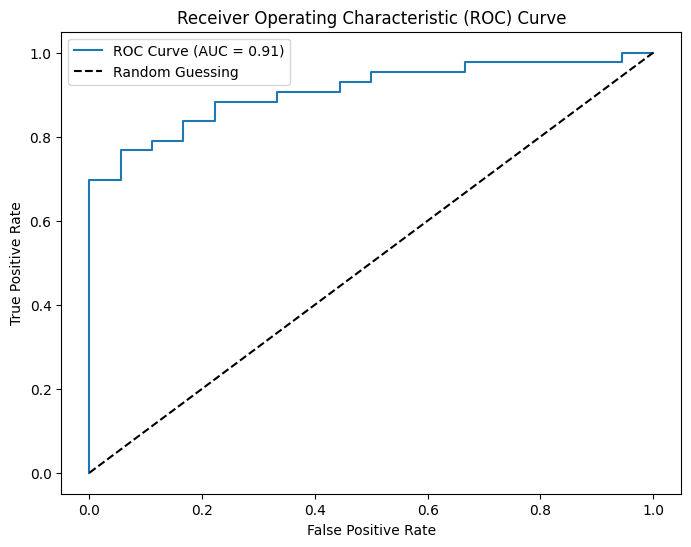

In [10]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Calculate confusion matrix
cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, (y_pred > 0.5).astype(int))
recall = recall_score(y_true, (y_pred > 0.5).astype(int))
f1 = f1_score(y_true, (y_pred > 0.5).astype(int))

# Print the metrics
print("Confusion Matrix:")
print(cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
[[ 0 18]
 [ 0 43]]
Precision: 0.7049180327868853
Recall: 1.0
F1 Score: 0.8269230769230769


In [12]:
import cv2
import os
import numpy as np
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Define the paths for tumor and non-tumor images
path_yes = r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset/yes/*'
path_no = r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset"/no/*'

# Load tumor images
tumor = []
for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))  # Label 1 for tumor images

# Load non-tumor images
no_tumor = []
for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Label 0 for non-tumor images

# Concatenate tumor and non-tumor images
all_data = tumor + no_tumor

# Shuffle the data
np.random.shuffle(all_data)

# Split data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the ResNet model with an attention mechanism
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the ResNet layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
attention_probs = GlobalAveragePooling2D()(base_model.output)
attention_probs = Dense(128, activation='relu')(attention_probs)
attention_probs = Dense(1, activation='sigmoid')(attention_probs)
attention_mul = Multiply()([base_model.output, attention_probs])

# Add classification head
x = GlobalAveragePooling2D()(attention_mul)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Save the model
model.save("brain_tumor_resnet_attention.h5")


Epoch 1/10
4/4 [==============================] - 12s 2s/step - loss: 0.4679 - accuracy: 0.8788 - val_loss: 0.1359 - val_accuracy: 1.0000
Epoch 2/10
4/4 [==============================] - 4s 936ms/step - loss: 0.1189 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 1.0000
Epoch 3/10
4/4 [==============================] - 4s 962ms/step - loss: 0.0350 - accuracy: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 4/10
4/4 [==============================] - 5s 1s/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 5/10
4/4 [==============================] - 4s 918ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 6/10
4/4 [==============================] - 4s 919ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 7/10
4/4 [==============================] - 4s 902ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 8/10
4/4 [=========

c:\Users\KEERTHI KRISHANA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
model.save("brain_tumor_resnet_attention.h5")

In [76]:
pip install opencv-python

  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)
Note: you may need to restart the kernel to use updated packages.


Epoch 1/50
6/6 [==============================] - 29s 3s/step - loss: 0.7576 - accuracy: 0.3867 - val_loss: 0.6873 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 0.6800 - accuracy: 0.6354 - val_loss: 0.6869 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 12s 2s/step - loss: 0.6803 - accuracy: 0.6409 - val_loss: 0.6856 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 12s 2s/step - loss: 0.6774 - accuracy: 0.6409 - val_loss: 0.6840 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 11s 2s/step - loss: 0.6739 - accuracy: 0.6409 - val_loss: 0.6816 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 6/50
6/6 [==============================] - 11s 2s/step - loss: 0.6647 - accuracy: 0.6409 - val_loss: 0.6776 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 7/50
6/6 [==============================] - 11s 2s/step - loss: 0.6515 - accuracy: 0.640

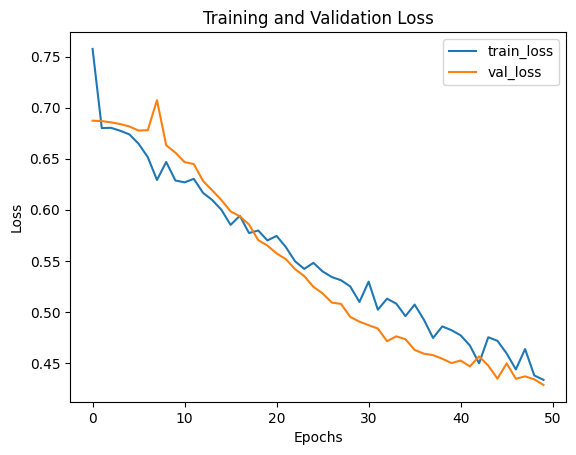

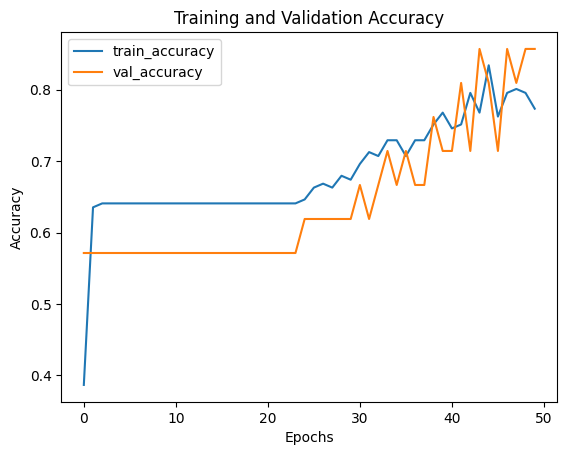

c:\Users\KEERTHI KRISHANA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
import cv2
import os
import numpy as np
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Define the paths for tumor and non-tumor images
path_yes = r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset/yes/*'
path_no = r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset/no/*'

# Load tumor images
tumor = []
for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))  # Label 1 for tumor images

# Load non-tumor images
no_tumor = []
for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Label 0 for non-tumor images

# Concatenate tumor and non-tumor images
all_data = tumor + no_tumor

# Shuffle the data
np.random.shuffle(all_data)

# Split data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Split the dataset into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Normalize pixel values
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Define the ResNet model with an attention mechanism
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the ResNet layers
for layer in base_model.layers:
    layer.trainable = False

# Add attention mechanism
attention_probs = GlobalAveragePooling2D()(base_model.output)
attention_probs = Dense(128, activation='relu')(attention_probs)
attention_probs = Dense(1, activation='sigmoid')(attention_probs)
attention_mul = Multiply()([base_model.output, attention_probs])

# Add classification head
x = GlobalAveragePooling2D()(attention_mul)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_binary = np.round(y_pred).astype(int)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save("brain_tumor_resnet_attention.h5")

2/2 [==============================] - 3s 409ms/step
Accuracy: 0.7254901960784313
Confusion Matrix:
[[13 11]
 [ 3 24]]
Precision: 0.6857142857142857
Recall: 0.8888888888888888
AUC: 0.736111111111111


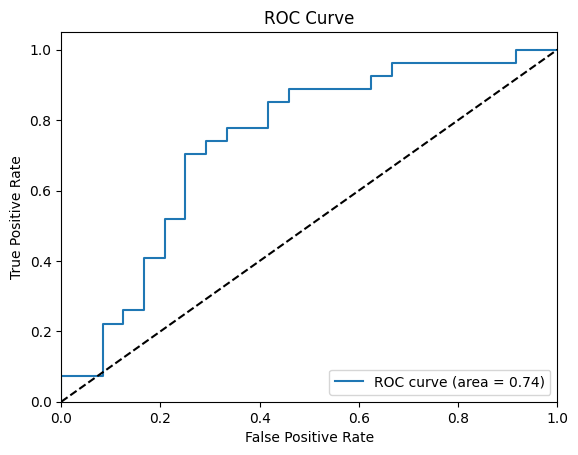

In [20]:
import cv2
import os
import numpy as np
import glob
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model = load_model("brain_tumor_resnet_attention.h5")

# Load test data
# Assuming x_test, y_test are already defined

# Make predictions
y_pred = model.predict(x_test)
y_pred_binary = np.round(y_pred).flatten()

# Calculate evaluation metrics
accuracy = np.mean(y_pred_binary == y_test)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

2/2 [==============================] - 2s 413ms/step


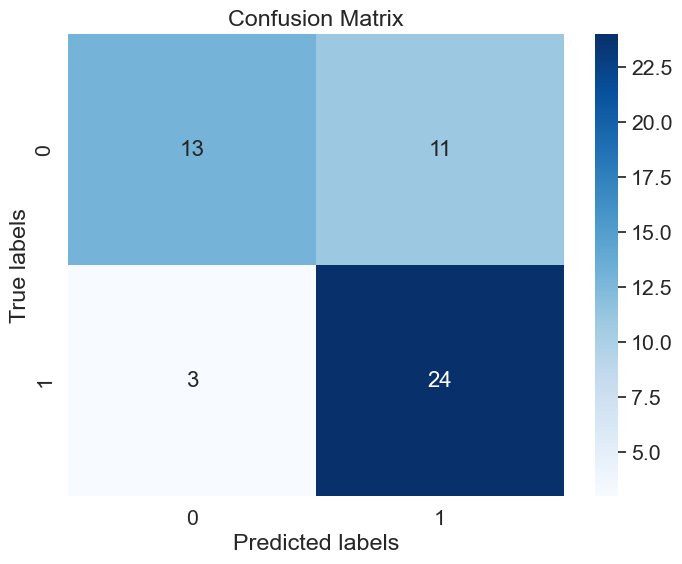

In [22]:
import cv2
import os
import numpy as np
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import ConfusionMatrixDisplay

# Load the model
model = load_model("brain_tumor_resnet_attention.h5")

# Make predictions
y_pred = model.predict(x_test)
y_pred_binary = np.round(y_pred).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.8888888888888888
Specificity (True Negative Rate): 0.5416666666666666


Epoch 1/30
6/6 [==============================] - 10s 931ms/step - loss: 0.8515 - accuracy: 0.4475 - val_loss: 0.8833 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 2/30
6/6 [==============================] - 5s 889ms/step - loss: 0.7339 - accuracy: 0.6243 - val_loss: 0.8530 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 3/30
6/6 [==============================] - 5s 912ms/step - loss: 0.6549 - accuracy: 0.6630 - val_loss: 0.7097 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 4/30
6/6 [==============================] - 5s 875ms/step - loss: 0.6648 - accuracy: 0.6685 - val_loss: 0.7003 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 5/30
6/6 [==============================] - 4s 675ms/step - loss: 0.6155 - accuracy: 0.6519 - val_loss: 0.7706 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 6/30
6/6 [==============================] - 4s 660ms/step - loss: 0.6373 - accuracy: 0.6630 - val_loss: 0.7467 - val_accuracy: 0.4762 - lr: 0.0010
Epoch 7/30
6/6 [==============================] - 4s 657ms/step - loss: 0.6342 - 

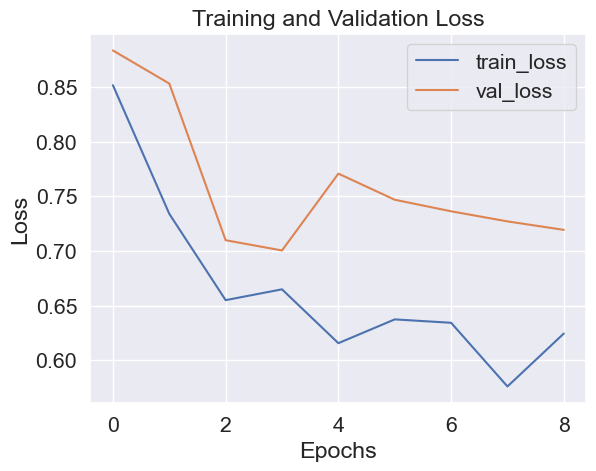

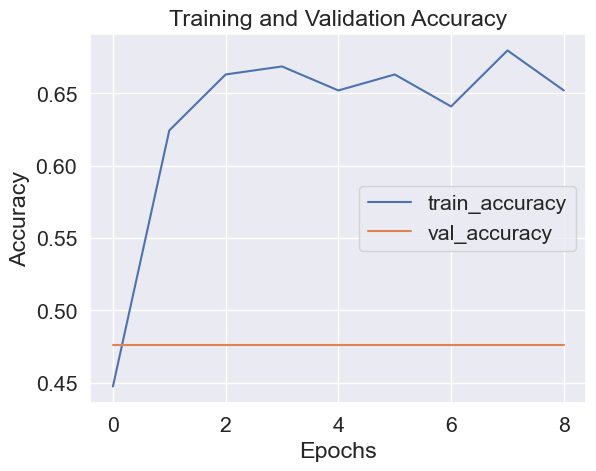

c:\Users\KEERTHI KRISHANA\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
import cv2
import os
import numpy as np
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

# Define the paths for tumor and non-tumor images
path_yes = r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset/yes/*'
path_no = r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset/no/*'

# Load tumor images
tumor = []
for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))  # Label 1 for tumor images

# Load non-tumor images
no_tumor = []
for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Label 0 for non-tumor images

# Concatenate tumor and non-tumor images
all_data = tumor + no_tumor

# Shuffle the data
np.random.shuffle(all_data)

# Split data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Split the dataset into training, validation, and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Normalize pixel values
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

# Define the ResNet model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the ResNet layers
for layer in base_model.layers:
    layer.trainable = False

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model on the test set
y_pred = model.predict(x_test)
y_pred_binary = np.round(y_pred).astype(int)

# Calculate evaluation metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save("brain_tumor_resnet_no_attention.h5")


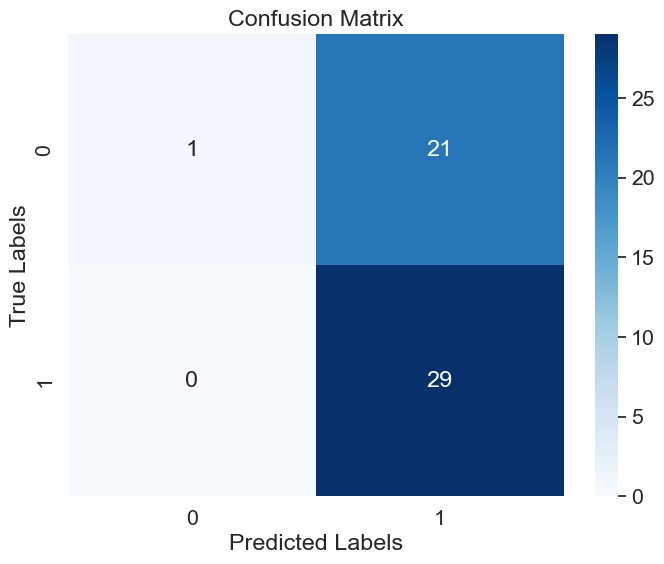

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [27]:
# Calculate sensitivity (true positive rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])

# Calculate specificity (true negative rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)


Sensitivity (True Positive Rate): 1.0
Specificity (True Negative Rate): 0.045454545454545456


# Resnet - 50

2/2 [==============================] - 2s 584ms/step
Accuracy: 0.5882352941176471
Confusion Matrix:
[[ 1 21]
 [ 0 29]]
Precision: 0.58
Recall: 1.0
AUC: 0.5736677115987461


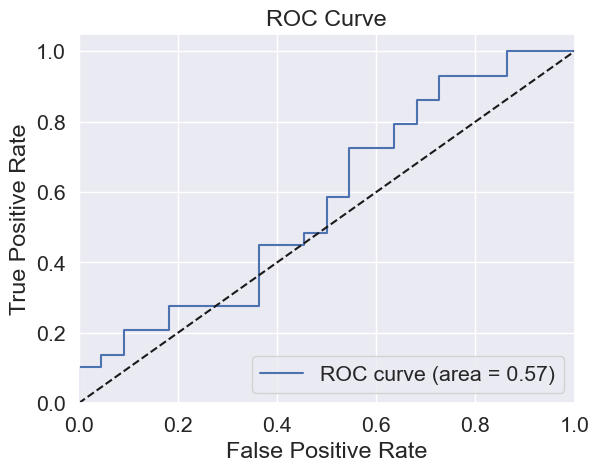

In [28]:
import cv2
import os
import numpy as np
import glob
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model
model = load_model("brain_tumor_resnet_no_attention.h5")

# Load test data
# Assuming x_test, y_test are already defined

# Make predictions
y_pred = model.predict(x_test)
y_pred_binary = np.round(y_pred).flatten()

# Calculate evaluation metrics
accuracy = np.mean(y_pred_binary == y_test)
conf_matrix = confusion_matrix(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Precision:", precision)
print("Recall:", recall)
print("AUC:", auc)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# CNN

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the dataset
data = keras.utils.image_dataset_from_directory(r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset')

Found 253 files belonging to 2 classes.


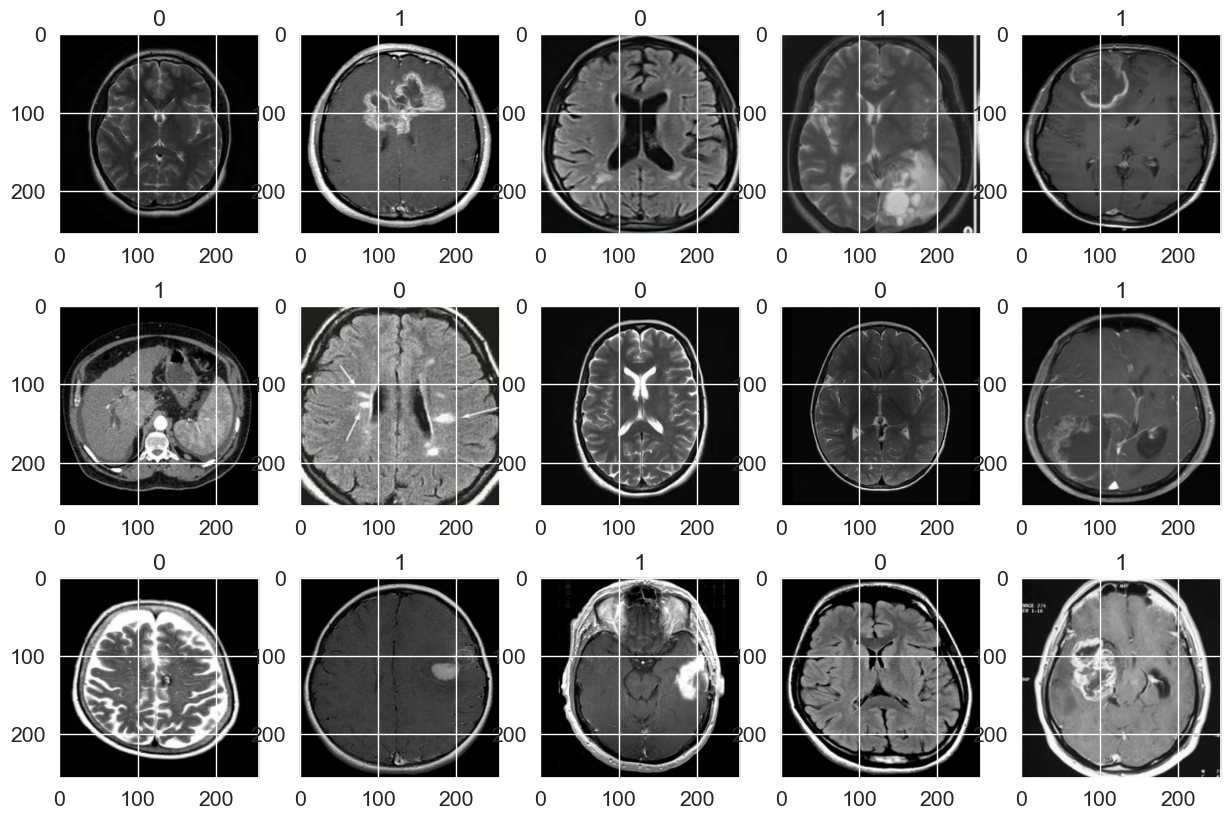

In [31]:
# Display sample images from the dataset
batch = data.as_numpy_iterator().next()
fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:15]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

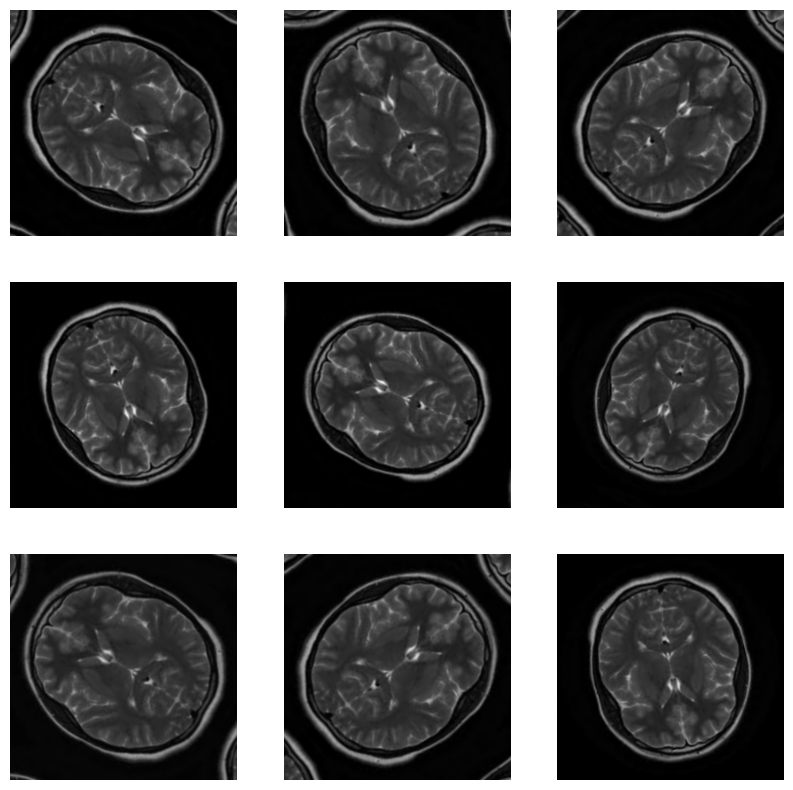

In [32]:
# Normalize and split the dataset
data = data.map(lambda x, y: (x / 255, y))
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.2) + 1
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomRotation(0.2)
])

# Display augmented images
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(batch[0][0:1])  # Assuming `batch[0][0:1]` is an image
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.axis("off")

In [33]:
# Define the model
model = keras.Sequential([
    data_augmentation,
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (5, 5), 1, activation="relu", padding="same"),
    layers.Conv2D(32, (5, 5), 1, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

# Compile the model
model.compile(optimizer="adam", loss=keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

Epoch 1/15
4/4 [==============================] - 12s 2s/step - loss: 0.7892 - accuracy: 0.6641 - val_loss: 0.6040 - val_accuracy: 0.7656
Epoch 2/15
4/4 [==============================] - 6s 1s/step - loss: 0.6179 - accuracy: 0.7422 - val_loss: 0.5710 - val_accuracy: 0.6719
Epoch 3/15
4/4 [==============================] - 6s 2s/step - loss: 0.6104 - accuracy: 0.6719 - val_loss: 0.4882 - val_accuracy: 0.7812
Epoch 4/15
4/4 [==============================] - 6s 1s/step - loss: 0.5827 - accuracy: 0.6953 - val_loss: 0.5014 - val_accuracy: 0.8125
Epoch 5/15
4/4 [==============================] - 6s 1s/step - loss: 0.5121 - accuracy: 0.7656 - val_loss: 0.5253 - val_accuracy: 0.7188
Epoch 6/15
4/4 [==============================] - 6s 2s/step - loss: 0.5746 - accuracy: 0.7344 - val_loss: 0.5800 - val_accuracy: 0.7188
Epoch 7/15
4/4 [==============================] - 6s 1s/step - loss: 0.5728 - accuracy: 0.7344 - val_loss: 0.5011 - val_accuracy: 0.7812
Epoch 8/15
4/4 [========================

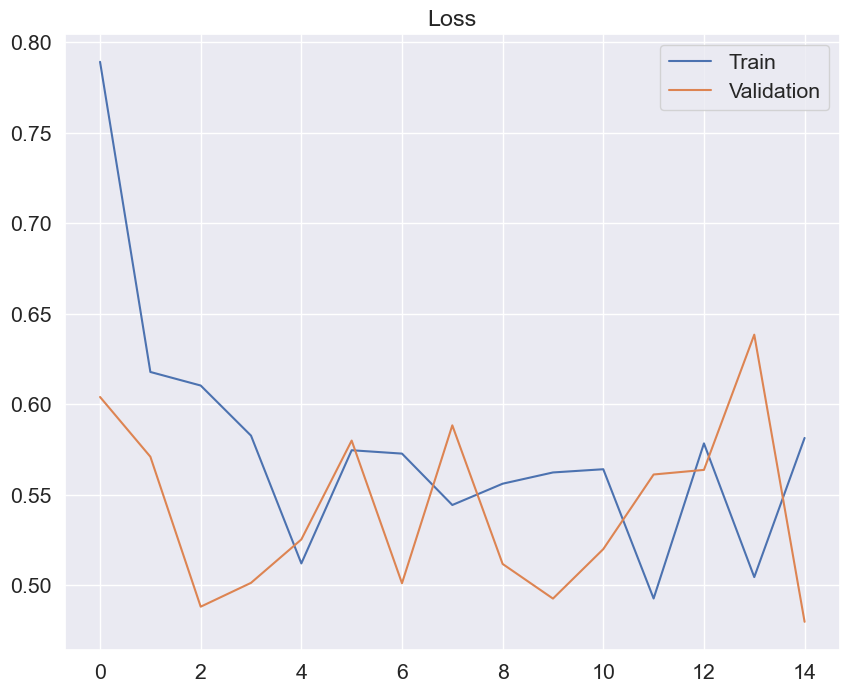

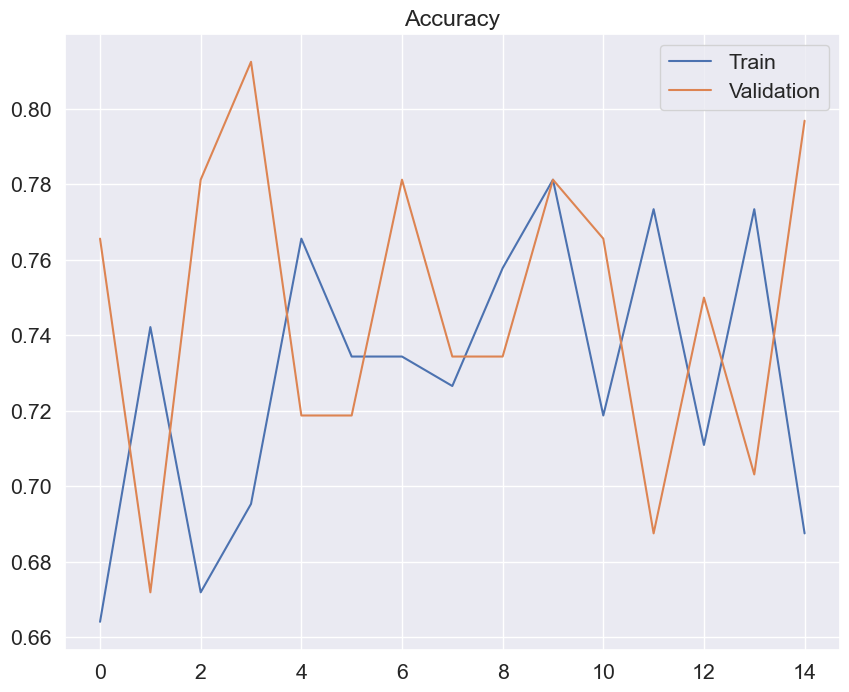

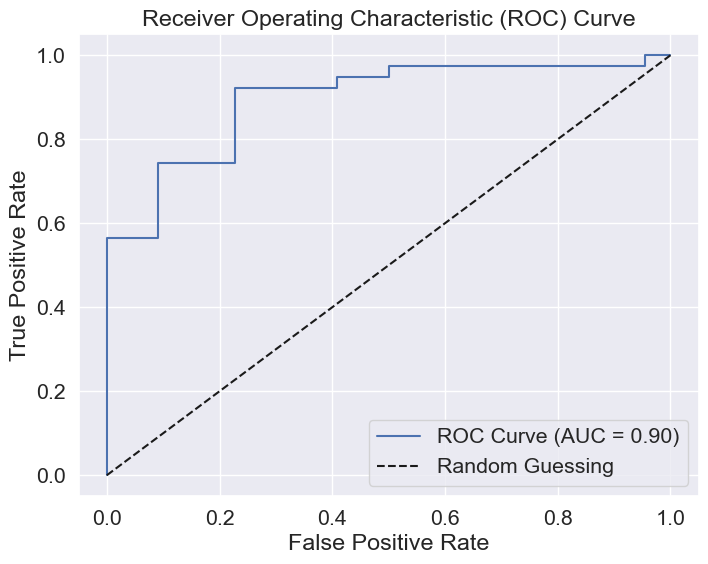

In [34]:
# Train the model
history = model.fit(train, epochs=15, validation_data=val)

# Visualize training history
plt.figure(figsize=(10, 8))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.figure(figsize=(10, 8))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

# Evaluate the model
bin_acc = keras.metrics.BinaryAccuracy()
recall = keras.metrics.Recall()
precision = keras.metrics.Precision()
y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    bin_acc.update_state(y, yhat)
    recall.update_state(y, yhat)
    precision.update_state(y, yhat)

    y_true_list.append(y)
    y_pred_list.append(yhat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Print evaluation metrics
print("Accuracy:", bin_acc.result().numpy())
print("Recall:", recall.result().numpy())
print("Precision:", precision.result().numpy())
print("F1 Score:", f1_score(y_true, (y_pred > 0.5).astype(int)))
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


In [35]:
# Calculate True Positive (TP), True Negative (TN), False Positive (FP), False Negative (FN)
TP = np.sum((y_true == 1) & (y_pred > 0.5))
TN = np.sum((y_true == 0) & (y_pred <= 0.5))
FP = np.sum((y_true == 0) & (y_pred > 0.5))
FN = np.sum((y_true == 1) & (y_pred <= 0.5))

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)


Sensitivity: 0.5737704918032787
Specificity: 0.4262295081967213


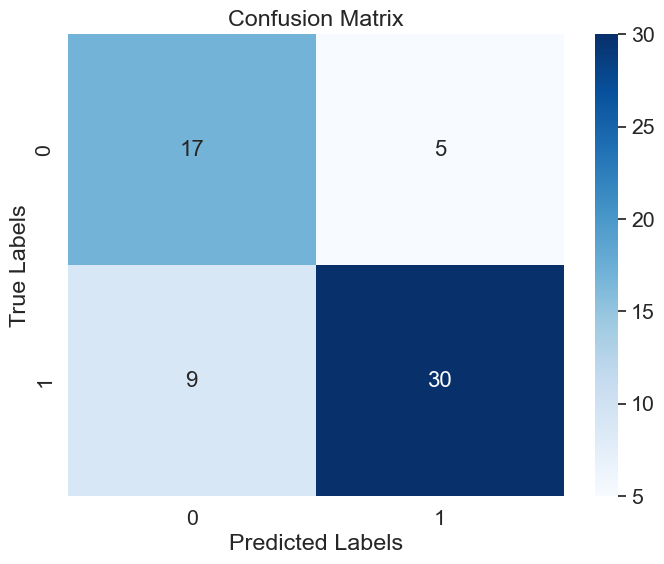

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, (y_pred > 0.5))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# VGG--19

Found 253 files belonging to 2 classes.
Epoch 1/15
4/4 [==============================] - 51s 13s/step - loss: 24.4176 - accuracy: 0.6719 - val_loss: 13.7265 - val_accuracy: 0.6875
Epoch 2/15
4/4 [==============================] - 45s 12s/step - loss: 15.1888 - accuracy: 0.5938 - val_loss: 3.6252 - val_accuracy: 0.7812
Epoch 3/15
4/4 [==============================] - 39s 11s/step - loss: 7.2856 - accuracy: 0.7656 - val_loss: 9.3396 - val_accuracy: 0.7500
Epoch 4/15
4/4 [==============================] - 39s 11s/step - loss: 3.6678 - accuracy: 0.8359 - val_loss: 1.3396 - val_accuracy: 0.9062
Epoch 5/15
4/4 [==============================] - 42s 12s/step - loss: 2.6171 - accuracy: 0.8281 - val_loss: 2.3025 - val_accuracy: 0.8281
Epoch 6/15
4/4 [==============================] - 43s 12s/step - loss: 0.6717 - accuracy: 0.9453 - val_loss: 0.6046 - val_accuracy: 0.9531
Epoch 7/15
4/4 [==============================] - 41s 11s/step - loss: 0.3827 - accuracy: 0.9375 - val_loss: 0.6277 - val_a

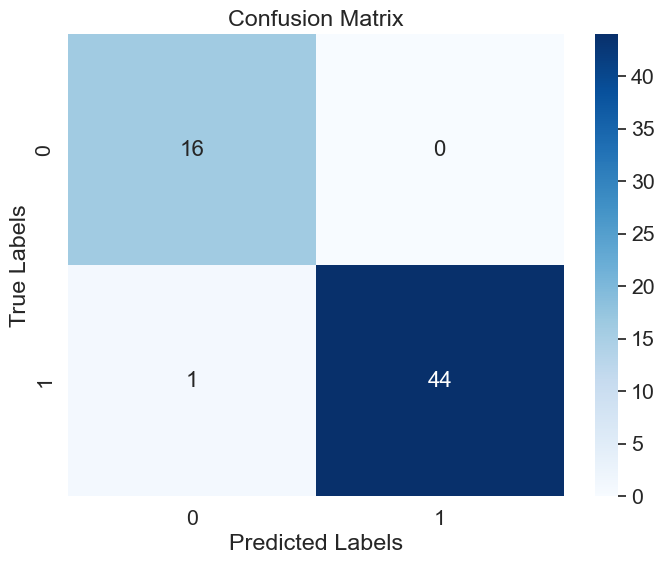

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = keras.utils.image_dataset_from_directory(r'C:\Users\KEERTHI KRISHANA\OneDrive\Documents\brain_tumor_dataset')

# Divide the dataset into train, validation, and test sets
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.2) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Define the VGG-19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train, epochs=15, validation_data=val)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

# Predictions
y_true_list = []
y_pred_list = []

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    y_true_list.append(y)
    y_pred_list.append(yhat)

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)

# Calculate metrics
f1 = f1_score(y_true, (y_pred > 0.5).astype(int))
roc_auc = roc_auc_score(y_true, y_pred)

# Print metrics
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Calculate confusion matrix
cm = confusion_matrix(y_true, (y_pred > 0.5).astype(int))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
